# Loading Data

In [3]:
from tslearn.datasets import UCR_UEA_datasets
from ClassificationModels.CNN_T import UCRDataset

import sklearn
import numpy as np 
import os
import pandas as pd

os.environ["CUDA_VISIBLE_DEVICES"]="" # To avoid use of GPU
import torch 

In [6]:
# dataset='ECG5000'
# dataset='ECG200'
dataset = 'Epilepsy'

In [7]:
train_x, train_y, test_x, test_y=UCR_UEA_datasets().load_dataset(dataset)
train_x

array([[[ 0.35,  0.22,  0.55],
        [ 0.4 ,  0.01,  0.51],
        [ 0.44, -0.71,  0.52],
        ...,
        [ 0.62,  0.72,  0.5 ],
        [ 0.65, -0.9 ,  0.55],
        [ 0.69, -1.3 ,  0.54]],

       [[-0.91, -0.05,  0.06],
        [-0.92, -0.02, -1.57],
        [-0.95,  0.01, -0.99],
        ...,
        [-0.47,  0.88, -0.95],
        [-0.45,  0.8 , -0.83],
        [-0.45,  0.76, -0.78]],

       [[ 0.32,  1.  ,  0.37],
        [ 0.71, -1.33,  0.37],
        [ 0.7 , -1.44,  0.37],
        ...,
        [ 0.59, -1.04,  0.45],
        [ 0.59,  0.47, -0.64],
        [ 0.59,  1.23,  0.66]],

       ...,

       [[ 1.16,  0.9 , -1.03],
        [-0.02,  0.59, -1.11],
        [-1.04,  0.52, -0.88],
        ...,
        [-0.51,  0.29, -0.02],
        [-0.94,  0.29, -0.02],
        [-0.48,  0.29, -0.02]],

       [[-0.74, -0.19, -0.14],
        [-0.14, -0.24, -0.26],
        [ 0.12, -0.34, -0.27],
        ...,
        [-0.4 , -0.54, -0.45],
        [-0.23, -0.43, -0.86],
        [-0.27,

In [192]:
#For use with CNN reverse Data Dimensions

if dataset in ['ECG200','ECG5000','Epilepsy']:
    train_x, train_y, test_x, test_y=UCR_UEA_datasets().load_dataset(dataset)
elif dataset == 'ptbxl':
    train_x = np.load(f'./datasets/ptbxl/x_train.npy')
    train_y = np.load(f'./datasets/ptbxl/y_train.npy')
    test_x = np.load(f'./datasets/ptbxl/x_test.npy')
    test_y = np.load(f'./datasets/ptbxl/y_test.npy')
else:
    print("ERROR: Dataset not found")

# 1 hot encoding outcomes
enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(np.vstack((train_y.reshape(-1,1),test_y.reshape(-1,1))))
train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))    

n_pred_classes =train_y.shape[1]
train_dataset = UCRDataset(train_x.astype(np.float64),train_y.astype(np.int64))
test_dataset = UCRDataset(test_x.astype(np.float64),test_y.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)

/mnt/c/D_drive/UCSD/Quarters/Q4/DSC261-RespDS/ts_causal_wsl/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [193]:
# train_x

In [194]:
# # Normalization
# print(f"Before norm on train, min={train_x.min()} and max={train_x.max()}")

# # Normalize along the feature axis
# mean = np.mean(train_x, axis=(0, 1), keepdims=True)  # Compute mean across samples and timesteps
# std = np.std(train_x, axis=(0, 1), keepdims=True)    # Compute std across samples and timesteps
# train_x = (train_x - mean) / std

# # Using same mean and std for test
# test_x = (test_x - mean) / std

# print(f"After norm on train, min={train_x.min()} and max={train_x.max()}")


# # 0-1 scaling
# print(f"Before 0-1 scaling on train, min={train_x.min()} and max={train_x.max()}")

# # Find the min and max values across the timesteps for each feature
# data_min = np.min(train_x, axis=(0, 1), keepdims=True)
# data_max = np.max(train_x, axis=(0, 1), keepdims=True)

# # Normalize to range [0, 1]
# train_x = (train_x - data_min) / (data_max - data_min)
# test_x = (test_x - data_min) / (data_max - data_min)
# print(f"Before 0-1 scaling on train, min={train_x.min()} and max={train_x.max()}")


In [195]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape, n_pred_classes

((137, 206, 3), (137, 4), (138, 206, 3), (138, 4), 4)

Train:

500 samples with 140 time span each and univariate time series (features=1).<br>
5 outcomes so categorical classification

Test:

4500 samples

In [196]:
model_path = './trained_models'
NumTimesteps = train_x.shape[-2]
NumFeatures = train_x.shape[-1]
NumTimesteps, NumFeatures


(206, 3)

# 1. LSTM Model

In [141]:
# from ClassificationModels.LSTM_T import LSTM
# from ClassificationModels.CNN_T import ResNetBaseline, get_all_preds, fit, UCRDataset

from XTSCBench.ClassificationModels.CNN_T import ResNetBaseline, UCRDataset,fit, get_all_preds
from XTSCBench.ClassificationModels.LSTM import LSTM

In [203]:

device='cpu'
hidden_size=200
rnn=0.3
input_size = train_x.shape[-1] # univariate or multi?

# Save model by this name
model_name = f'lstm_{dataset}_h{hidden_size}_drop{rnn}'


In [204]:
input_size

3

In [158]:

# if os.path.isfile(f'./saved_models/lstm_{dataset}'):
#     model =LSTM(input_size, hidden_size ,n_pred_classes,rnndropout=0.1).to(device) 
#     model = torch.load(f'./{model_path}/lstm_{dataset}')
# else:
model =LSTM(input_size, hidden_size ,n_pred_classes,rnndropout=rnn).to(device) 
fit(model,train_loader,test_loader, learning_rate=0.0001, patience=30)
torch.save(model, f'./{model_path}/{model_name}')

Epoch: 1, Train loss: 1.387, Val loss: 1.386
Epoch: 2, Train loss: 1.386, Val loss: 1.386
Epoch: 3, Train loss: 1.386, Val loss: 1.385
Epoch: 4, Train loss: 1.385, Val loss: 1.385
Epoch: 5, Train loss: 1.385, Val loss: 1.385
Epoch: 6, Train loss: 1.385, Val loss: 1.385
Epoch: 7, Train loss: 1.384, Val loss: 1.384
Epoch: 8, Train loss: 1.384, Val loss: 1.384
Epoch: 9, Train loss: 1.383, Val loss: 1.384
Epoch: 10, Train loss: 1.383, Val loss: 1.384
Epoch: 11, Train loss: 1.383, Val loss: 1.383
Epoch: 12, Train loss: 1.382, Val loss: 1.383
Epoch: 13, Train loss: 1.381, Val loss: 1.382
Epoch: 14, Train loss: 1.38, Val loss: 1.382
Epoch: 15, Train loss: 1.38, Val loss: 1.381
Epoch: 16, Train loss: 1.379, Val loss: 1.38
Epoch: 17, Train loss: 1.377, Val loss: 1.378
Epoch: 18, Train loss: 1.375, Val loss: 1.375
Epoch: 19, Train loss: 1.37, Val loss: 1.355
Epoch: 20, Train loss: 1.357, Val loss: 1.342
Epoch: 21, Train loss: 1.351, Val loss: 1.338
Epoch: 22, Train loss: 1.35, Val loss: 1.34
Epo

## Performance on Test Set

In [205]:
model= torch.load(f'./{model_path}/lstm_Epilepsy_h200_drop0.3_acc58')

/tmp/ipykernel_34482/413885844.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model= torch.load(f'./{model_path}/lstm_Epilepsy_h200_drop0.3_acc58')


In [206]:
model.eval()
test_preds, ground_truth = get_all_preds(model, test_loader)
ground_truth=np.argmax(ground_truth,axis=1)

In [207]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay

<Figure size 1000x1200 with 0 Axes>

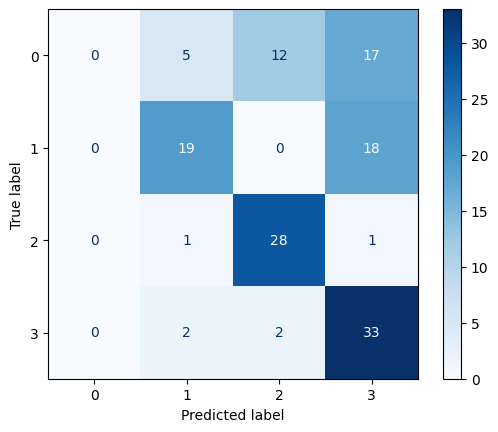

In [208]:
sns.reset_orig() 
# sns.set(rc={'figure.figsize':(10,12)})
plt.figure(figsize=(10,12))
# plt.grid(False)

heatmap=confusion_matrix(ground_truth, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=heatmap)
disp.plot(cmap=plt.cm.Blues)

# sns.heatmap(heatmap, annot=True, cmap="coolwarm")
plt.savefig(f'model_metrics/lstm/{model_name}_confusion_matrix.png')
plt.show()
# plt.close()

In [209]:
acc= accuracy_score(ground_truth, test_preds)
a = classification_report(ground_truth, test_preds, output_dict=True)
dataframe = pd.DataFrame.from_dict(a)
dataframe.to_csv(f'model_metrics/lstm/{model_name}_classification_report.csv')
dataframe.head()

/mnt/c/D_drive/UCSD/Quarters/Q4/DSC261-RespDS/ts_causal_wsl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/D_drive/UCSD/Quarters/Q4/DSC261-RespDS/ts_causal_wsl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/D_drive/UCSD/Quarters/Q4/DSC261-RespDS/ts_causal_wsl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.0,0.703704,0.666667,0.478261,0.57971,0.462158,0.461831
recall,0.0,0.513514,0.933333,0.891892,0.57971,0.584685,0.579710
f1-score,0.0,0.593750,0.777778,0.622642,0.57971,0.498542,0.495216
support,34.0,37.000000,30.000000,37.000000,0.57971,138.000000,138.000000


# 2. CNN Model

Resnet

mode=feat for CNN

In [172]:
model = ResNetBaseline(in_channels=NumFeatures, num_pred_classes=n_pred_classes)
train_dataset = UCRDataset(train_x.astype(np.float64).reshape(-1,NumFeatures,NumTimesteps),train_y.astype(np.int64))
test_dataset = UCRDataset(test_x.astype(np.float64).reshape(-1,NumFeatures,NumTimesteps),test_y.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)

In [173]:
model_name = f'cnn_{dataset}'

In [179]:
fit(model,train_loader,test_loader, patience=10)
torch.save(model, f'./{model_path}/{model_name}')

Epoch: 1, Train loss: 0.478, Val loss: 0.519
Epoch: 2, Train loss: 0.224, Val loss: 0.946
Epoch: 3, Train loss: 0.233, Val loss: 1.014
Epoch: 4, Train loss: 0.23, Val loss: 0.448
Epoch: 5, Train loss: 0.131, Val loss: 0.389
Epoch: 6, Train loss: 0.046, Val loss: 0.326
Epoch: 7, Train loss: 0.037, Val loss: 0.394
Epoch: 8, Train loss: 0.125, Val loss: 0.411
Epoch: 9, Train loss: 0.291, Val loss: 0.521
Epoch: 10, Train loss: 0.127, Val loss: 0.418
Epoch: 11, Train loss: 0.074, Val loss: 0.335
Epoch: 12, Train loss: 0.175, Val loss: 0.389
Epoch: 13, Train loss: 0.144, Val loss: 0.456
Epoch: 14, Train loss: 0.077, Val loss: 0.406
Epoch: 15, Train loss: 0.032, Val loss: 0.34
Epoch: 16, Train loss: 0.014, Val loss: 0.414
Early stopping!


## Performance on Test Set

In [180]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay

In [181]:
model.eval()
test_preds, ground_truth = get_all_preds(model, test_loader)
ground_truth=np.argmax(ground_truth,axis=1)

<Figure size 1000x1200 with 0 Axes>

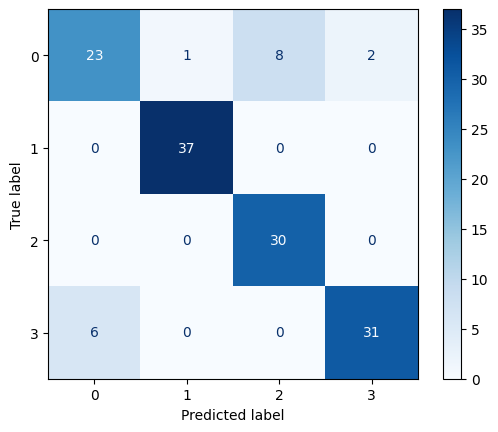

In [182]:
# sns.reset_orig() 
# sns.set(rc={'figure.figsize':(10,12)})
plt.figure(figsize=(10,12))
# plt.grid(False)

heatmap=confusion_matrix(ground_truth, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=heatmap)
disp.plot(cmap=plt.cm.Blues)

# sns.heatmap(heatmap, annot=True, cmap="coolwarm")
plt.savefig(f'model_metrics/lstm/{model_name}_confusion_matrix.png')
plt.show()
# plt.close()

In [184]:
acc= accuracy_score(ground_truth, test_preds)
a = classification_report(ground_truth, test_preds, output_dict=True)
dataframe = pd.DataFrame.from_dict(a)
dataframe.to_csv(f'model_metrics/lstm/{model_name}_classification_report.csv')
dataframe.head()

,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.793103,0.973684,0.789474,0.939394,0.876812,0.873914,0.879954
recall,0.676471,1.000000,1.000000,0.837838,0.876812,0.878577,0.876812
f1-score,0.730159,0.986667,0.882353,0.885714,0.876812,0.871223,0.873725
support,34.000000,37.000000,30.000000,37.000000,0.876812,138.000000,138.000000


# 3. Transformer Model

In [10]:
from XTSCBench.ClassificationModels.Transformer import Transformer

2024-12-01 01:13:26.536497: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-01 01:13:27.177530: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-01 01:13:29.235729: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-01 01:13:29.235770: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-01 01:13:29.260570: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [13]:
model=Transformer(input_size=train_x.shape[0], seq_len=NumTimesteps, N=6, heads=5, dropout=0.1, num_classes=n_pred_classes, time=50)

In [14]:
model

Transformer(
  (encoder): Encoder(
    (pe): PositionalEncoder(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (norm_1): Norm()
        (norm_2): Norm()
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=500, out_features=500, bias=True)
          (v_linear): Linear(in_features=500, out_features=500, bias=True)
          (k_linear): Linear(in_features=500, out_features=500, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (out): Linear(in_features=500, out_features=500, bias=True)
        )
        (ff): FeedForward(
          (linear_1): Linear(in_features=500, out_features=400, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear_2): Linear(in_features=400, out_features=500, bias=True)
        )
        (dropout_1): Dropout(p=0.1, inplace=False)
        (dropout_2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): Norm()
  )
  (out)

In [17]:
fit(model,train_loader,test_loader)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (8000x2 and 500x5)